In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
import operator
from sklearn import cluster
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import math
from wordcloud import WordCloud
from collections import defaultdict
from gensim.parsing.porter import PorterStemmer

In [2]:
YEAR = 2016
NUM_RELEVANT_WORDS = 2000
NUM_CLUSTERS = 25

df = pd.read_csv('news_headlines.csv')
uw_df = pd.read_csv('useless_words.csv')
df.describe()

stemmer= PorterStemmer()

# process input

headlines_by_year = defaultdict(list)
original_headlines_by_year = defaultdict(list)
bag_of_words_by_year = defaultdict(lambda: defaultdict(int))

useless_words = set(uw_df['useless_words'])
remove_characters = '!@#:;\'\"*)([]{}%.,&'
ignore_characters = '$0123456789'

print("|" + " "*101 + "|")
print("|", end="")
for i in range(len(df)):
    if i%(len(df)//100) == 0:
        print("=",end="")    
    year =  int(df['publish_date'][i]) // 10000
    if year != YEAR:
        continue
    original_headlines_by_year[year].append(df['headline_text'][i])
    words = df['headline_text'][i].split()
    headline = []
    for w in words:
        bad_word = False
        for r in w:
            if r in ignore_characters:
                bad_word = True
                break
        if bad_word:
            continue
        if w not in useless_words:
            stemmed_word = stemmer.stem(w.translate({i: None for i in remove_characters}))
            headline.append(stemmed_word)
            bag_of_words_by_year[year][stemmed_word] += 1
    headlines_by_year[year].append(headline)
print("|")


|                                                                                                     |
|=====================================================================================================|


In [3]:
BoW = bag_of_words_by_year[YEAR]
relevant_words = list(sorted(BoW.items(),key=operator.itemgetter(1))[-NUM_RELEVANT_WORDS:])

print(len(relevant_words))

indices = {word[0]:ind for ind, word in enumerate(relevant_words)}

print(indices)

2000
{'mackai': 1211, 'condit': 1457, 'asylum': 1585, 'un': 1579, 'propos': 1670, 'strong': 1348, 'govt': 1333, 'mildura': 370, 'infrastructur': 360, 'seri': 794, 'conflict': 1, 'histori': 1637, 'debat': 1743, 'travel': 1225, 'husband': 132, 'guilti': 1872, 'confirm': 1565, 'role': 1031, 'system': 1594, 'around': 1085, 'pro': 609, 'doe': 1364, 'jack': 693, 'fight': 1876, 'slow': 784, 'think': 329, 'reaction': 293, 'car': 1971, 'illawarra': 330, 'cancel': 1262, 'crop': 1036, 'itali': 405, 'survivor': 1519, 'space': 1167, 'transform': 168, 'pass': 1213, 'mill': 48, 'defenc': 1527, 'hurt': 468, 'too': 1290, 'match': 1454, 'clinic': 396, 'wilson': 770, 'april': 877, 'flat': 859, 'onli': 634, 'gambl': 528, 'korean': 371, 'riot': 84, 'rocket': 27, 'privatis': 202, 'david': 1716, 'gain': 1209, 'colour': 278, 'shock': 1082, 'us': 1998, 'basin': 317, 'alert': 1087, 'price': 1887, 'region': 1771, 'turkei': 1477, 'sister': 735, 'cathol': 795, 'app': 1006, 'compass': 291, 'art': 1802, 'ceasefir': 

In [4]:
matrix = np.zeros((len(headlines_by_year[YEAR]),len(relevant_words)))

for row, hl in enumerate(headlines_by_year[YEAR]):
    for word in hl:
        if word in indices:
            matrix[row,indices[word]] = 1

print(matrix.shape)

(33538, 2000)


2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

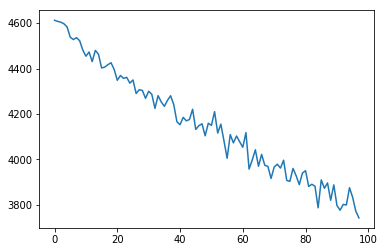

In [34]:

#grid search

if True:
    grid_search_matrix = np.array(matrix)
    np.random.shuffle(grid_search_matrix)
    grid_search_matrix = grid_search_matrix[:1000,:]

    labels = list(range(2,100))
    inertias = []

    for i in labels:
        print(i,end=' ')
        kmeans = cluster.KMeans(i,verbose = 0)
        kmeans.fit(grid_search_matrix)
        inertias.append(kmeans.inertia_)

    plt.plot(list(range(len(inertias))), [i for i in inertias])
    plt.show()


In [7]:
kmeans = cluster.KMeans(NUM_CLUSTERS)
kmeans.fit(matrix)
print(kmeans.labels_)

[ 2  2  2 ...  4 23 14]


In [8]:
clusters = []
print("Generating cluster ", end='')

for i in range(NUM_CLUSTERS):
    print("{}, ".format(i),end='')
    nth_cluster = []
    filtered_matrix = matrix[kmeans.labels_ == i]
    for r in range(filtered_matrix.shape[0]):
        for c in range(filtered_matrix.shape[1]):
            if filtered_matrix[r][c] > 0:
                nth_cluster.append(relevant_words[c][0])
    clusters.append(nth_cluster)
print("")

Generating cluster 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 


Cluster 0 : 317 headlines
Most common words: women afl team more young rugbi trump leagu violenc competit
Closest to centroid:
   heather oconnor womens movement
   meg nagle breastfeeding women
   women apprentices


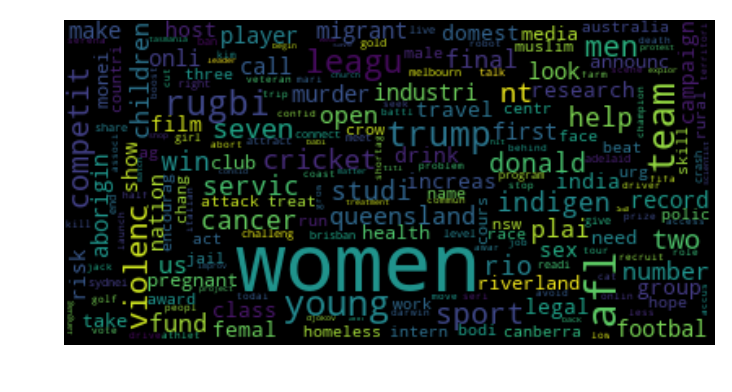

Cluster 1 : 121 headlines
Most common words: sexual assault abus charg alleg child girl children accus teen
Closest to centroid:
   sexual harassment widespread in sapol
   wendy harmer sexual fluidity
   man charged over sexual assault in girrawheen in 1989


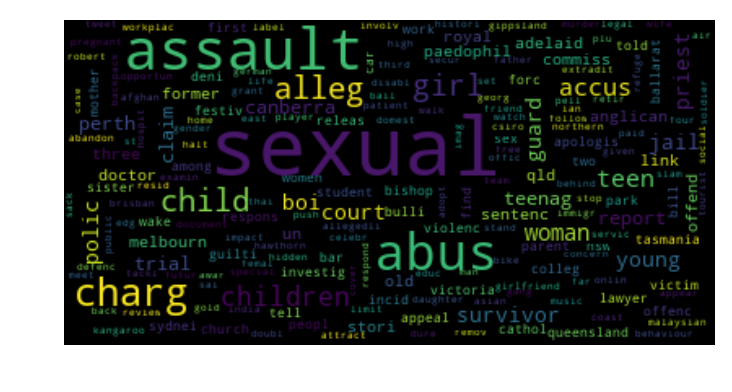

Cluster 2 : 26374 headlines
Most common words: us govern call nsw court sydnei queensland trump adelaid melbourn
Closest to centroid:
   'now showing' with zak hepburn
   'twiggy' forrest on australian of the year
   10 years of offsiders


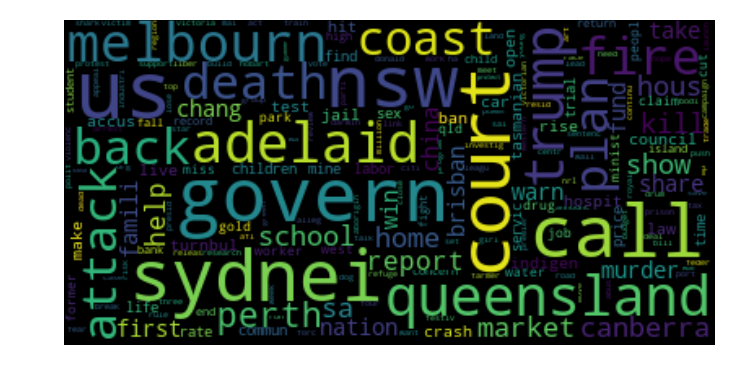

Cluster 3 : 298 headlines
Most common words: tasmania hydro west weather flood northern warn coast more polic
Closest to centroid:
   tractor trekking in tasmania
   wicked campers with vile slogans to be outlawed in tasmania
   orienteering tasmania offers direction for navigators


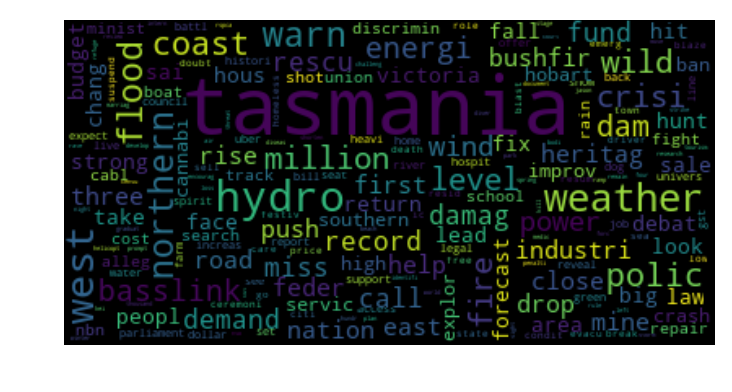

Cluster 4 : 284 headlines
Most common words: di ag be crash hospit hit car woman fall fire
Closest to centroid:
   australian goalkeeper stefan petrovski dies struck lightning
   elvis presley guitarist scotty moore dies at 84
   cubas fidel castro dies aged 90


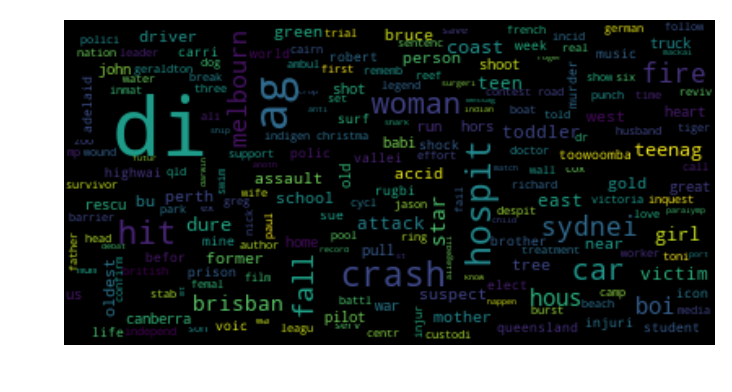

Cluster 5 : 201 headlines
Most common words: big bash countri leagu sydnei thunder bank wave next final
Closest to centroid:
   countdown to sanfl big day
   a big country glamping grey nomads
   a big country listening out for the superb lyrebird


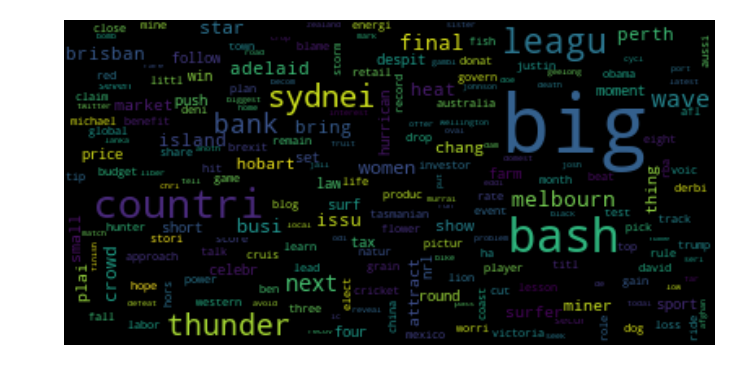

Cluster 6 : 293 headlines
Most common words: health mental sa hospit servic fund minist patient call report
Closest to centroid:
   nude yoga baring all health relaxation
   buddy franklin mental health sledge
   canada ibm payroll debacle echoes queensland health


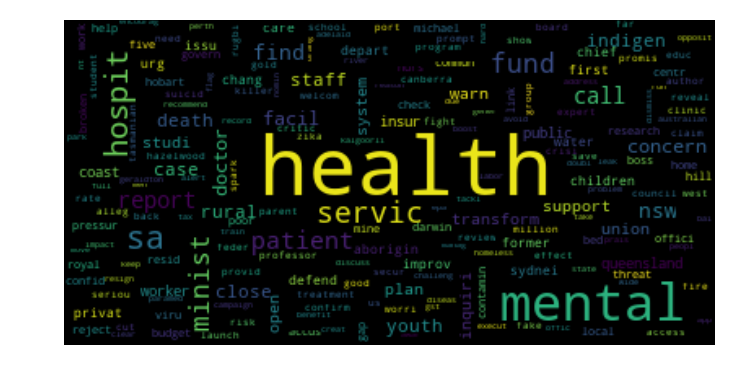

Cluster 7 : 202 headlines
Most common words: guilti plead murder charg child accus canberra woman death sex
Closest to centroid:
   coughing truckie kenneth laurence pillar guilty
   radovan karadzic found guilty of genocide
   bowe maddigan pleads guilty to murdering zoe buttigieg


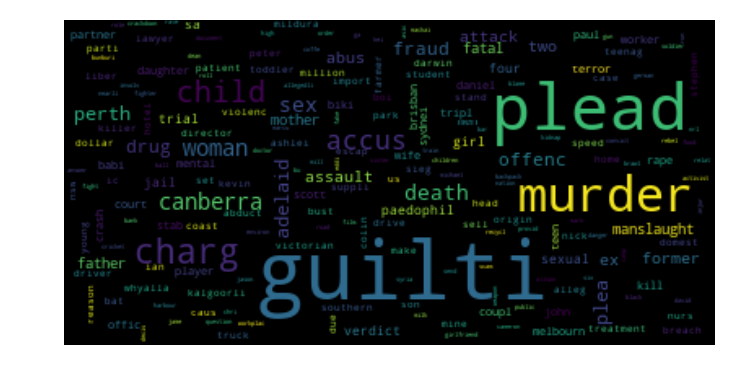

Cluster 8 : 61 headlines
Most common words: kyrgio nick open tomic bernard andi cup murrai french beat
Closest to centroid:
   stosur kyrgios advance in madrid
   nick kyrgios and daria gavrilova win hopman cup for australia
   french open: stosur in; kyrgios out


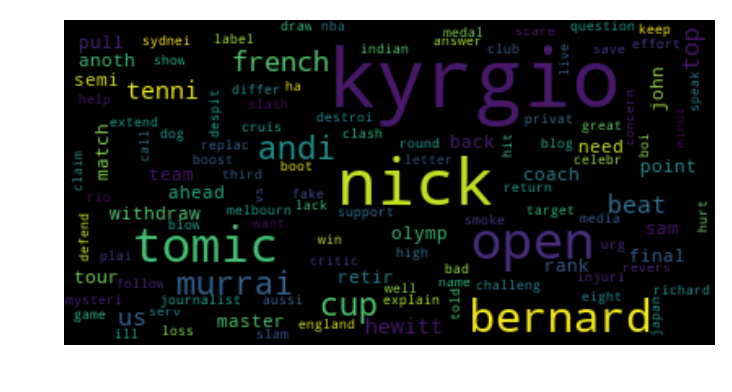

Cluster 9 : 327 headlines
Most common words: flood weather rain nsw warn heavi victoria bom damag sever
Closest to centroid:
   clermont flood of 1916
   peaches split from weather
   100 homes flooded in forbes


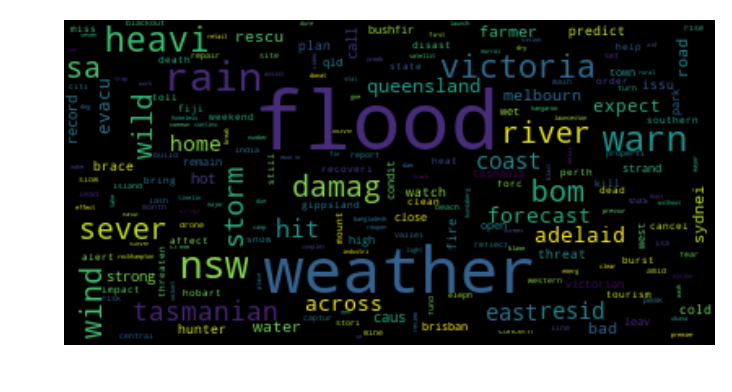

Cluster 10 : 290 headlines
Most common words: state islam origin govern attack nsw unit mosul queensland us
Closest to centroid:
   state of origin robbie farah laurie daley furious at referees
   state of origin sidelines
   timbumburi state debating champs


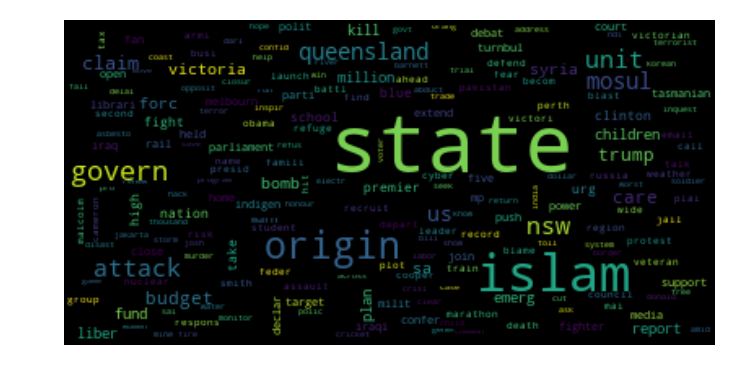

Cluster 11 : 327 headlines
Most common words: two men crash car dead fire kill polic arrest peopl
Closest to centroid:
   us transfers two guantanamo detainees to serbia
   australia aims to capitalise on day two at mcg
   around the world on a bicycle built for two


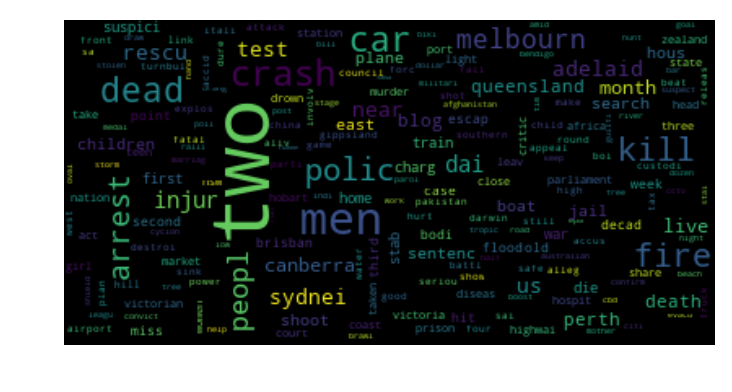

Cluster 12 : 65 headlines
Most common words: new abc quiz sport breakfast septemb june mai speak decemb
Closest to centroid:
   abc news quiz
   abc news quiz
   abc news quiz


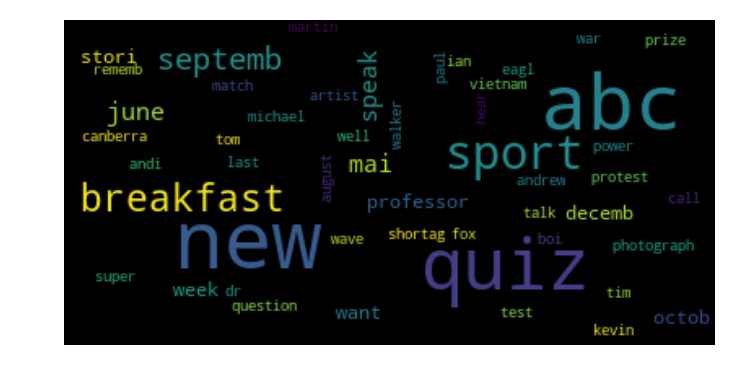

Cluster 13 : 246 headlines
Most common words: final grand nrl afl leagu semi shark beat melbourn open
Closest to centroid:
   aurora australis finally refloated
   philae lander finally found on comet 67p
   sanfl finals


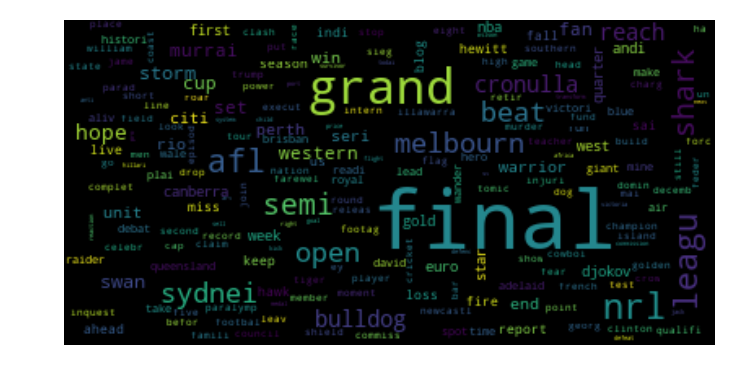

Cluster 14 : 416 headlines
Most common words: woman charg polic death murder car kill dead miss melbourn
Closest to centroid:
   missing woman found
   missing woman niangala
   perth woman chloe christos bleeding disorders haemophilia day


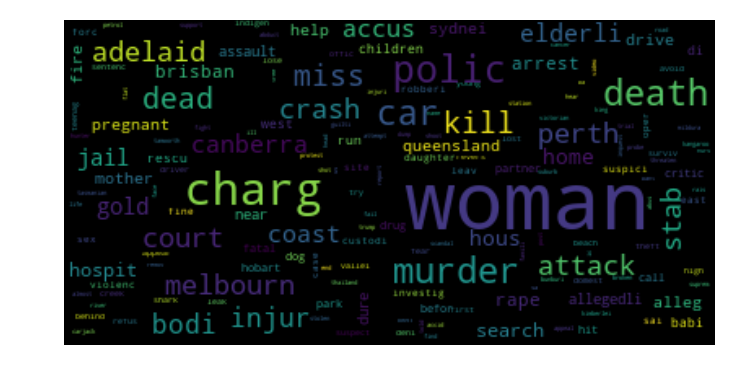

Cluster 15 : 638 headlines
Most common words: elect us trump campaign turnbul vote labor feder live clinton
Closest to centroid:
   election 2016 constituents grill fisher
   election 2016 derryn hinch liberty alliance
   fairfax election grill


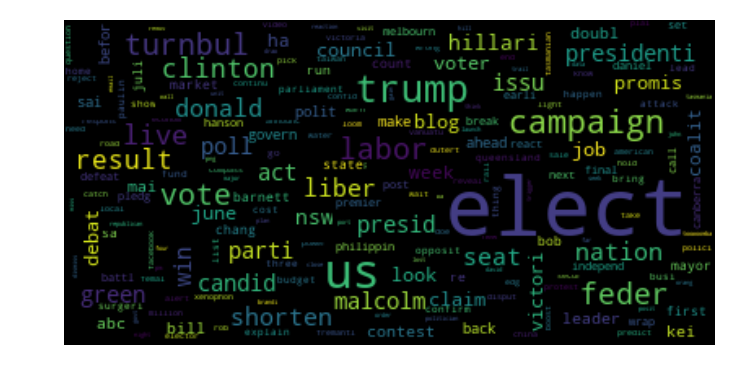

Cluster 16 : 491 headlines
Most common words: charg murder death sydnei child court face assault attack stab
Closest to centroid:
   hsbc currency traders charged with defrauding client
   rapper coolio charged with unlawful firearm posession
   man charged over 2009 murder of mohammed haddara


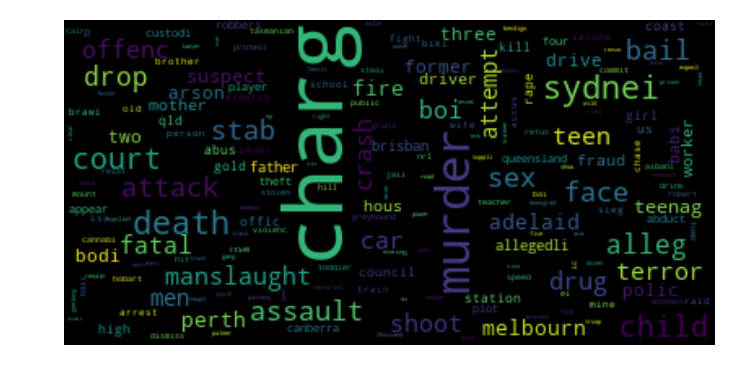

Cluster 17 : 187 headlines
Most common words: senat nation elect culleton inquiri vote labor rod seat court
Closest to centroid:
   allan mull senate candidate
   abcc passes the senate
   senate loosens photography rules


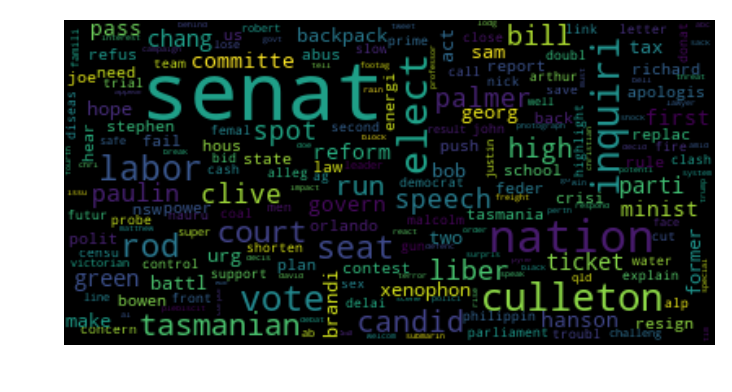

Cluster 18 : 85 headlines
Most common words: juli wide drum bishop bai april fridai octob decemb februari
Closest to centroid:
   corelogic july rental index
   saturday agenda: july 16
   saturday agenda: july 30


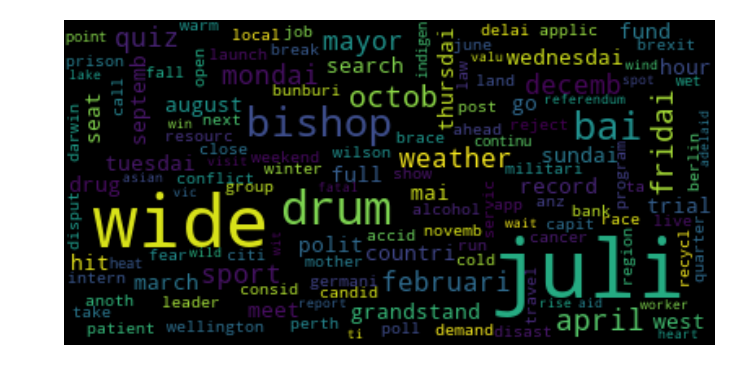

Cluster 19 : 468 headlines
Most common words: rio olymp game gold team paralymp medal seven athlet ban
Closest to centroid:
   belcher sick at rio 2016 sailing venue
   elaine thompson and usain bolt impress on day 12 rio
   matildas at their strongest for rio 2016


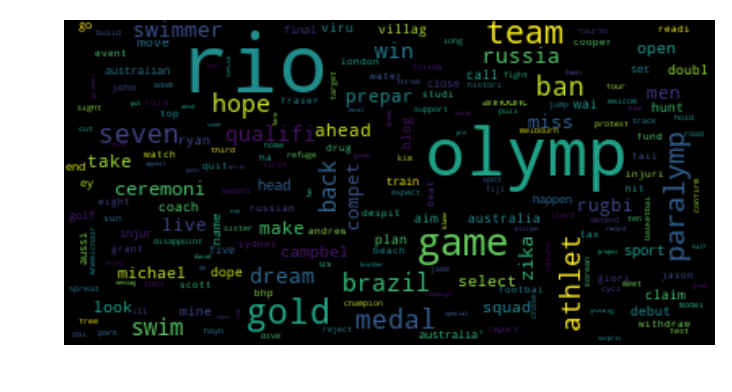

Cluster 20 : 318 headlines
Most common words: driver near crash truck hit jail car road bu kill
Closest to centroid:
   unaccompanied learner driver clocked at 181kph near muchea
   underage drivers nabbed on wa road
   driver shaken after sinkhole swallows car


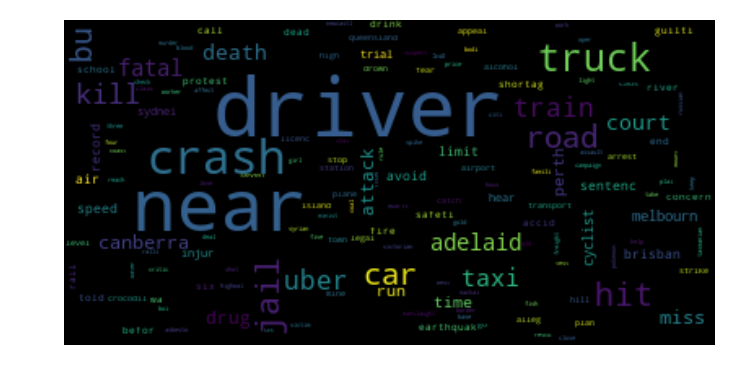

Cluster 21 : 240 headlines
Most common words: busi speak small tasmanian confid lobbi against budget council indigen
Closest to centroid:
   alibaba australian businesses
   brad banducci speaks to the business
   emma herd speaks to the business


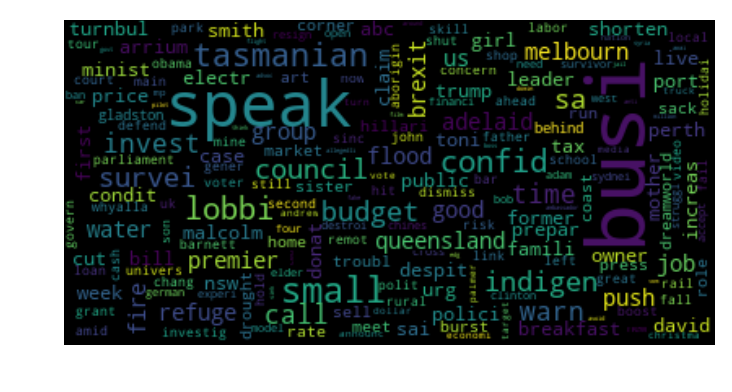

Cluster 22 : 81 headlines
Most common words: korea missil test nuclear us launch fire sanction un iran
Closest to centroid:
   indonesians 'in love' with south korea
   north korea restarts coded spy broadcasts south says
   north korea condemed for nuclear tests


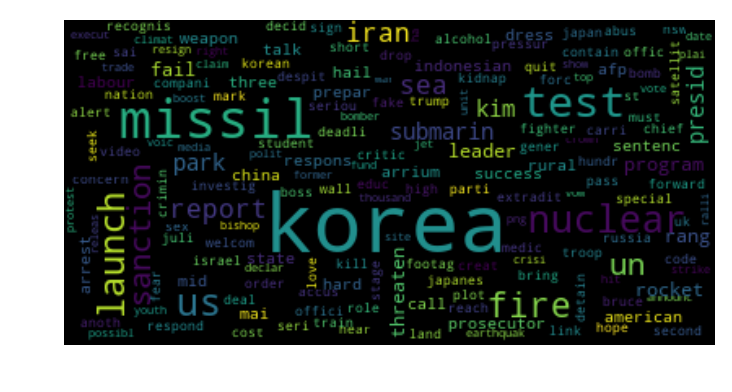

Cluster 23 : 926 headlines
Most common words: polic offic shoot nsw sai investig car arrest search drug
Closest to centroid:
   police at pulse nightclub after shooting
   police shooting in cowra
   northam police pursuit


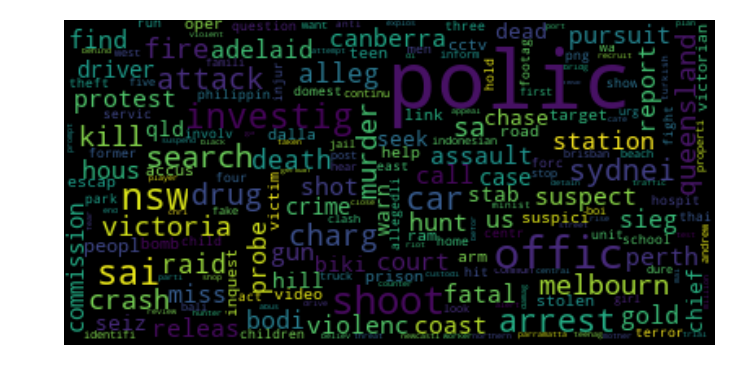

Cluster 24 : 282 headlines
Most common words: nt polic govern elect indigen youth commiss detent royal former
Closest to centroid:
   magnolia maymuru to represent nt at miss world
   malarndirri mccarthy not enrolled to vote in nt
   nt waterfowl season 2016


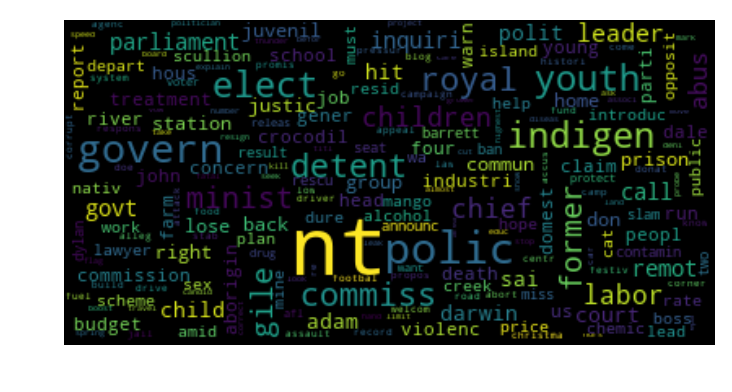

In [9]:
biggest = (-1,-1)
for ind, nth_cluster in enumerate(clusters):
    number = len(kmeans.labels_[kmeans.labels_ == ind])
    print("Cluster", ind, ":", number , "headlines")
    biggest = max(biggest,(number,ind))
    # Most common words:
    if True:
        freq = defaultdict(int)
        for i in nth_cluster:
            freq[i] += 1
        most_common_words = sorted([(-freq[i],i) for i in freq.keys()])[:10]
        print("Most common words:"," ".join([i[1] for i in most_common_words]))

    # Closest to centroid:
    if True:
        print("Closest to centroid:")
        headlines_in_centroid = []
        for ind2, headline in enumerate(original_headlines_by_year[YEAR]):
            if kmeans.labels_[ind2] != ind:
                continue
            dist = np.linalg.norm(kmeans.cluster_centers_[ind] - matrix[ind2])
            headlines_in_centroid.append((dist,headline,headlines_by_year[YEAR][ind2]))
        headlines_in_centroid.sort()
        for i in headlines_in_centroid[:3]:
            print("  ",i[1])
            
    # Show wordcloud:
    if True:
        wordcloud = WordCloud(max_font_size=50,collocations=False).generate(" ".join(sorted(nth_cluster)))
        plt.figure(dpi=140)
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.show()


In [15]:
a = np.array([[1,0],[2,1],[3,2],[4,3]])

b = [True, False, True, False]

print(a[b])

[[1 0]
 [3 2]]


fitting TSNE
(33538, 2000) (33538,)
(33538, 2001)
(26374, 2)
(1000, 2000) (1000,)
(1000, 2)


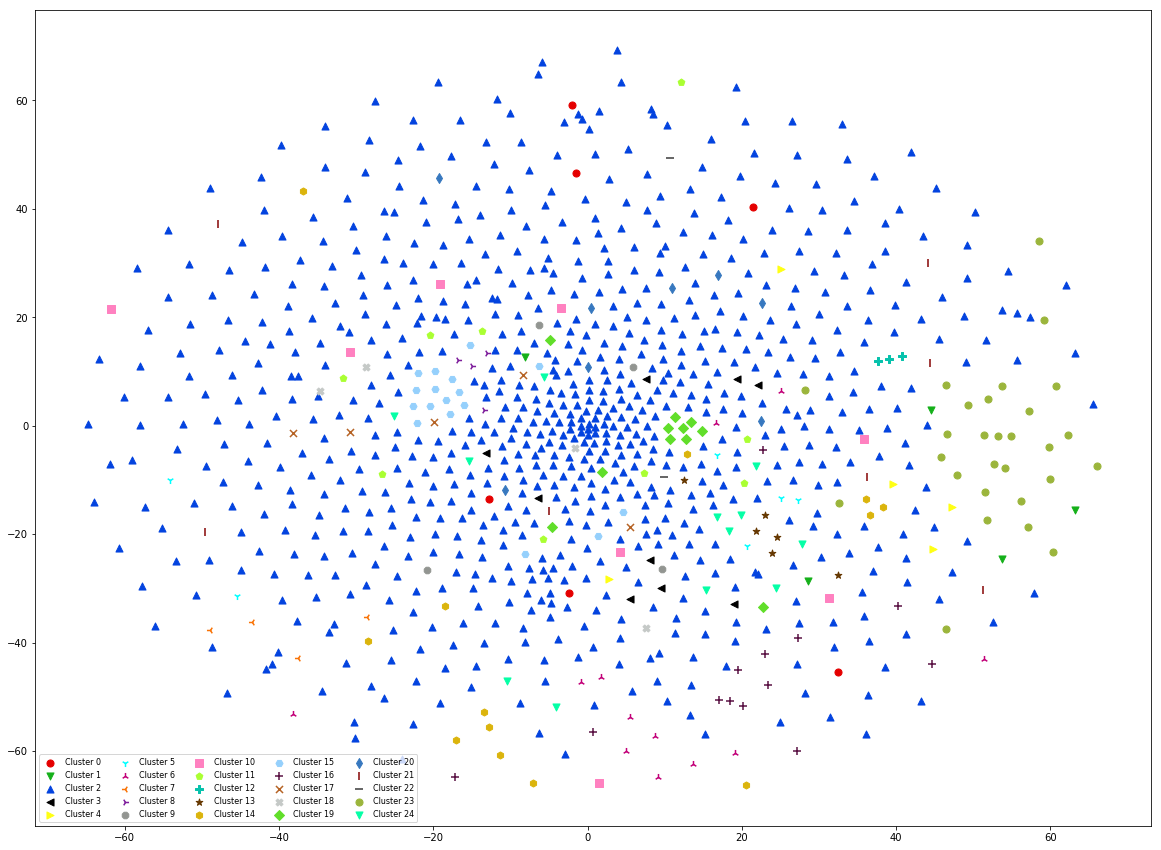

without biggest: 2
(1000, 2)


AttributeError: module 'matplotlib.pyplot' has no attribute 'label'

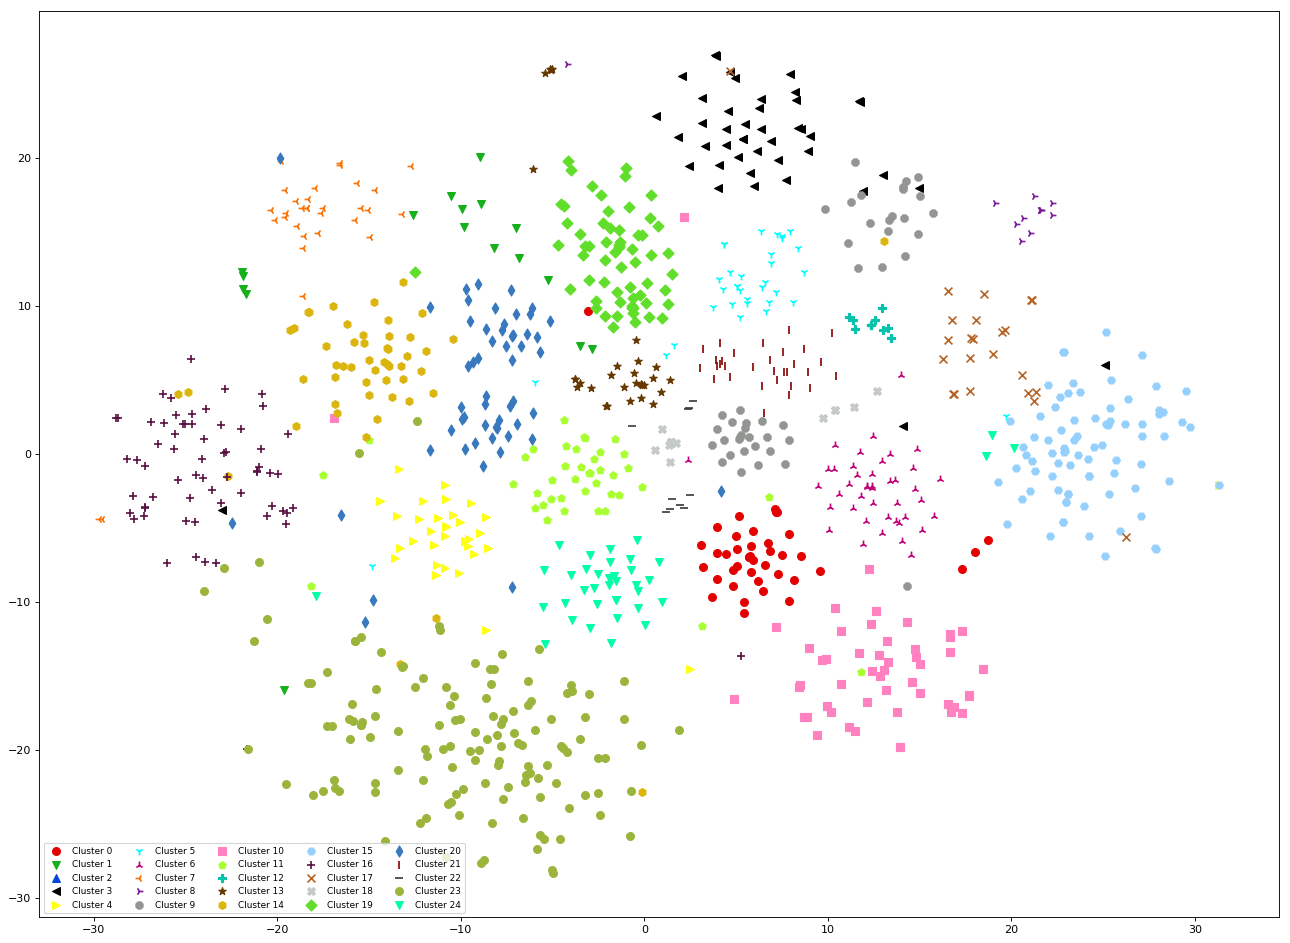

In [33]:
# show t-SNE visualisation

colors = [
"xkcd:red",
"xkcd:green",
"xkcd:blue",
"xkcd:black",
"xkcd:yellow",
"xkcd:cyan",
"xkcd:magenta",
"xkcd:orange",
"xkcd:purple",
"xkcd:gray",
"xkcd:pink",
"xkcd:lime",
"xkcd:turquoise",
"xkcd:brown",
"xkcd:gold",
"xkcd:light blue",
"xkcd:plum",
"xkcd:copper",
"xkcd:silver",
"xkcd:toxic green",
"xkcd:windows blue",
"xkcd:dark red",
"xkcd:dark gray",
"xkcd:booger",
"xkcd:bright sea green",
]*2

markers = [
"o",
"v",
"^",
"<",
">",
"1",
"2",
"3",
"4",
"8",
"s",
"p",
"P",
"*",
"h",
"H",
"+",
"x",
"X",
"D",
"d",
"|",
"_",
] * 3

print("fitting TSNE")

print(matrix.shape, kmeans.labels_.shape)

sample = np.hstack((matrix,kmeans.labels_.reshape((len(kmeans.labels_),1))))
print (sample.shape)
np.random.shuffle(sample)
print(biggest)

# with biggest
sample1 = sample[:1000,:-1]
labels1 = sample[:1000,-1]
print(sample1.shape, labels1.shape)
tsne = TSNE(n_components=2).fit_transform(sample1)
print(tsne.shape)
plt.figure(figsize=(20, 15))
for i in range(NUM_CLUSTERS):
    cluster1 = tsne[labels1 == i]
    plt.scatter(cluster1[:,0],cluster1[:,1],c=colors[i],marker=markers[i],s=50)
plt.legend(tuple(scatters),
           tuple(["Cluster {}".format(i) for i in range(NUM_CLUSTERS)]),
           scatterpoints=1,
           loc='lower left',
           ncol=5,
           fontsize=8)
plt.show()
    
print("without biggest:",biggest[1])

sample2 = sample[sample[:,-1]!=biggest[1]][:1000,:-1]
labels2 = sample[sample[:,-1]!=biggest[1]][:1000,-1]

tsne = TSNE(n_components=2).fit_transform(sample2)
print(tsne.shape)
plt.figure(figsize=(20, 15), dpi=80, facecolor='w', edgecolor='k')
scatters = []
for i in range(NUM_CLUSTERS):
    cluster1 = tsne[labels2 == i]
    scatters += [plt.scatter(cluster1[:,0],cluster1[:,1],c=colors[i],marker=markers[i],s=50)]

plt.legend(tuple(scatters),
           tuple(["Cluster {}".format(i) for i in range(NUM_CLUSTERS)]),
           scatterpoints=1,
           loc='lower left',
           ncol=5,
           fontsize=8)

plt.label("t-SNE plot of clusters (without most common \"miscellaneous\" cluster)")
plt.show()

In [ ]:
print(clusters)

In [ ]:
# print(kmeans.cluster_centers_.shape)
# wordclouds = []
# for cluster in kmeans.cluster_centers_:
#     words = ""
#     for i in range(len(cluster)):
#         words += (sorted_dict[i][0] + ' ') * int(cluster[i]*100)
#     print(words)
#     wordclouds.append(WordCloud(max_font_size=50,collocations = False).generate(words))

In [ ]:
# for ind, i in enumerate(wordclouds):
#     print("Cluster",ind)
#     plt.figure(dpi=140)
#     plt.imshow(i, interpolation="bilinear")
#     plt.axis("off")
#     plt.show()